# Understanding CMS Disk Data


https://docs.google.com/document/d/1i-0uGs_wqsLBvrzK3QeHVhe_8vlMIe6gGryoE5gV_dM/edit#

## Import and Notebook Configuration

In [1]:

from datetime import datetime, date, timedelta
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime,
    to_date,
    countDistinct,
    collect_list
)
import calendar
import numpy as np
import pandas as pd
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

import pyspark.sql.functions as func

In [2]:
#Pandas options to not truncate columns 
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

In [3]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("DESIRED_CMSDataset", StringType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("CMS_SubmissionTool", StringType(), nullable=True),
                        StructField("CMS_TaskType", StringType(), nullable=True),
                        StructField("TaskType", StringType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_JobType", StringType(), nullable=True),
                        StructField("CMS_JobType", StringType(), nullable=True),
                        StructField("CRAB_ReqName", StringType(), nullable=True),
                        StructField("CRAB_UserHN", StringType(), nullable=True),
                        StructField("USER", StringType(), nullable=True),
                        StructField("Workflow", StringType(), nullable=True),
                        StructField("CRAB_Workflow", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True)
                        
                    ]
                ),
            ),
        ]
    )


In [4]:
def get_candidate_files(start_date, end_date, spark, base):
    
    # We check one date before and after the required dates
    # This ensures we do not miss records with events in different day than the date on the file
    # which may be the case due to delay in the processing queue
    # Later we filter records outside required timespan
    st_date = start_date - timedelta(days=1)
    ed_date = end_date + timedelta(days=1)
    days = (ed_date - st_date).days
    
    sc = spark.sparkContext
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
    # Uncomment below instead to include temp files: temp files might become unaccessible during code execution
    #     f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}{{,.tmp}}"
        for i in range(0, days)
    ]

    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    
    #https://hadoop.apache.org/docs/stable/api/org/apache/hadoop/fs/FileSystem.html#globStatus-org.apache.hadoop.fs.Path-
    #patter match to include temporary files
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    
    return candidate_files

### Data Source

In [5]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"
# HDFS_DBS_FILES = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/FILES/part-m-00000'
# HDFS_DBS_DATASETS = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/DATASETS/part-m-00000'

In [6]:
def get_past_n_days(days_range, end_date):
    timestamp = calendar.timegm(end_date.timetuple())
    end_datetime = datetime.utcfromtimestamp(timestamp)
    start_datetime = end_datetime - timedelta(days=days_range)
    return start_datetime, end_datetime



In [7]:
def get_raw_df(days_range, end_date=date.today()):
    
    schema = _get_schema()
    start_date, end_date = get_past_n_days(days_range, end_date)
    
    raw_df = (
            spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
            .json(
                get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
                schema=schema,
            )
            .select("data.*")
            .filter(col("RecordTime")>=start_date.timestamp() * 1000)
            .filter(col("RecordTime")<end_date.timestamp() * 1000)
    )
    return raw_df


#         .drop_duplicates(["GlobalJobId"])
#     )



In [8]:
def get_dataset_request_frequency(days_range, end_date=date.today()):
    
    raw_df = get_raw_df(days_range, end_date)
    # We filter:
    # Events with Submission tool as CRAB
    # Select a single instace of CRAB_Workflow - our concerened field `DESIRED_CMSDataset` is same for all such rows (check assumption check 1)
    # Drop rows with DESIRED_CMSDataset as "null" - these are Monte Carlo jobs and do not require presence of datasets

    df_filtered = raw_df\
            .filter(col("CMS_SubmissionTool")=='CRAB')\
            .filter(col("DESIRED_CMSDataset")!='null')\
            .drop_duplicates(["CRAB_Workflow"])
    
    # We aggregate:
    # Group on DESIRED_CMSDataset
    # - count CRAB_Workflow: this represent the frequency of request of the dataset
    # - count CRAB_UserHN: (Question: how can this help us?) : frequency of unique users requesting that dataset 

    df_aggregated = df_filtered\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(
                 countDistinct(col("CRAB_Workflow")).alias("dataset_request_frequency")
                )\
            .orderBy(col('dataset_request_frequency').desc())
    
    return df_aggregated
    

## For each day the amount of unique data requested by crab workflow in the past 7d/30d/60d
    - rough estimation of how much data crab need to be there
> **We are counting Number of crab workflows that began that day.**

In [9]:
def get_distinct_crab_workflow(n_days, pivot_on_datatier = False, datatiers = ["MINIAOD","MINIAODSIM","AOD","AODSIM"]):
    #Sum of size of datasets requested every day
    ## Convert timestamp to dates, group by and count on dates

    raw_df = get_raw_df(n_days)
    #We rank occurence of a Workflow and select the first occurence - essentially the one with lowest RecordTime
    windowPartitionWorkflow = Window.partitionBy("CRAB_Workflow").orderBy("RecordTime")
    
    #We filter the first occurence of a crab_workflow
    #Convert unix time stamp to date
    #count distinct crab workflow that executed on a day

    df_distinct_crab_workflow = raw_df\
            .filter(col("CMS_SubmissionTool")=='CRAB')\
            .filter(col("DESIRED_CMSDataset")!='null')\
            .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordTime', 'CMSPrimaryDataTier'])\
            .withColumn("TimeRank", func.row_number().over(windowPartitionWorkflow))\
            .filter(col("TimeRank")==1)\
            .withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000)))

    
    if pivot_on_datatier:
        df = df_distinct_crab_workflow\
                .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate', 'CMSPrimaryDataTier'])\
                .groupby('RecordDate').pivot("CMSPrimaryDataTier", datatiers).agg(countDistinct('CRAB_Workflow'))
    else:
        df = df_distinct_crab_workflow\
                .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate'])\
                .groupby('RecordDate').agg(countDistinct('CRAB_Workflow'))
        
    return df
    

<AxesSubplot:xlabel='RecordDate'>

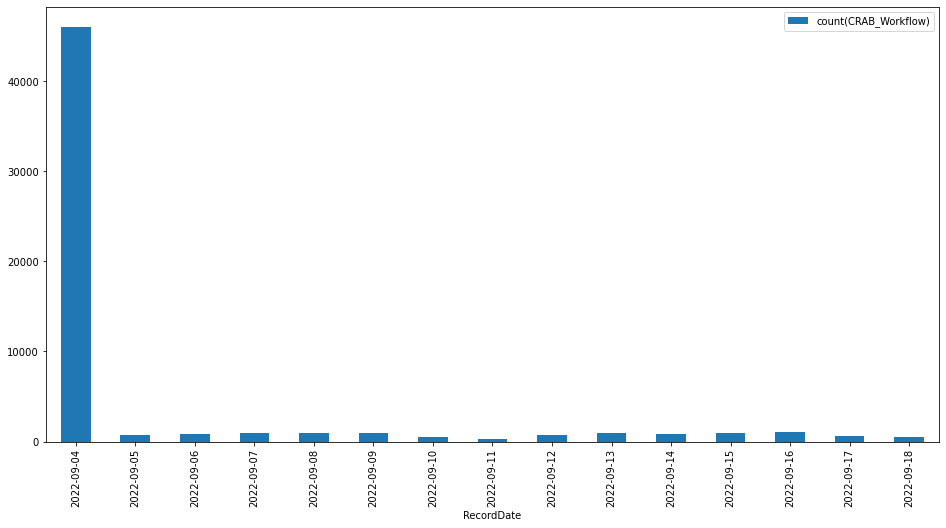

In [10]:
#Number of days
n_days = 15
pd_distinct_crab_workflow = get_distinct_crab_workflow(n_days).toPandas()
pd_distinct_crab_workflow.sort_values('RecordDate').set_index('RecordDate').plot.bar(figsize=(16, 8))

<AxesSubplot:xlabel='RecordDate'>

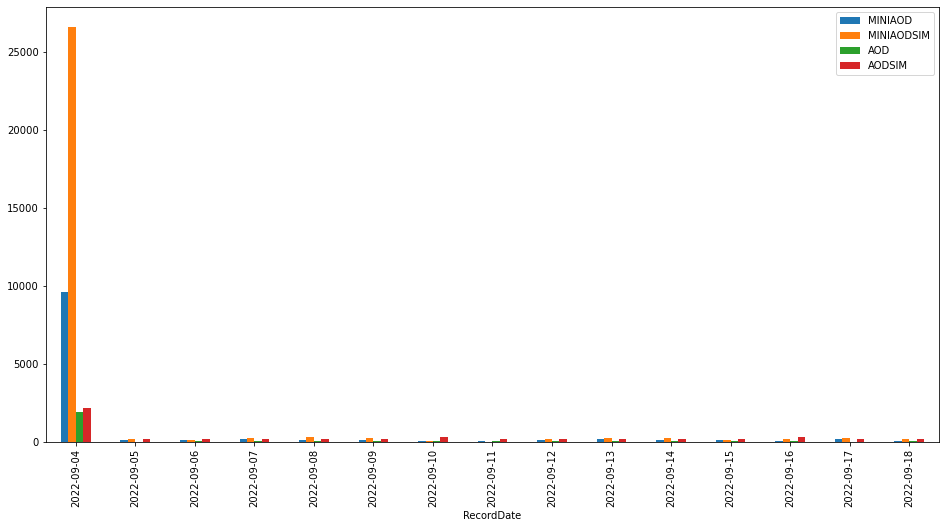

In [11]:
pd_distinct_crab_workflow_by_data_tier = get_distinct_crab_workflow(n_days, pivot_on_datatier=True).toPandas()

pd_distinct_crab_workflow_by_data_tier.sort_values('RecordDate').set_index('RecordDate').plot.bar(figsize=(16, 8))

## For each day the amount of new unique data requested w.r.t. the past 7d/30d/60d
	- estimating in this way the amount of new data to be transferred

> **Count of Difference between "the set of datasets used in the past n days" and "list of datasets used today"**

In [34]:
def get_dataset_per_day(days, end_date=None, datewiseUnique=True):
    
    if end_date is None:
        raw_df = get_raw_df(days)
    else:
        raw_df = get_raw_df(days, end_date)

    #We rank occurence of a Workflow and select the first occurence - essentially the one with lowest RecordTime
    windowPartitionWorkflow = Window.partitionBy("CRAB_Workflow").orderBy("RecordTime")
    
    df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset").isNotNull())\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordTime', 'CMSPrimaryDataTier'])\
        .withColumn("TimeRank", func.row_number().over(windowPartitionWorkflow))\
        .filter(col("TimeRank")==1)\
        .withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000)))\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate', 'CMSPrimaryDataTier'])

    
    if datewiseUnique:
        df = df.dropDuplicates(['DESIRED_CMSDataset', 'RecordDate'])
        
    return df
        

In [35]:

def get_count_new_unique_dataset_past_n_days(threshold_days, data_days, pivot_on_datatier = False):
    # threshold_days - Unique data with respect to past threshold days - 15 days for current rule time
    # number_of_days - Number of days to do analysis for - for daily runs - use 1, for weekly - 7
    
    datatiers = ["MINIAOD","MINIAODSIM","AOD","AODSIM"]
    unique_count_dict = {}

    
    for i in range(data_days):
        print(f"Running for {i}th day")
        today = date.today() - timedelta(i)
        yesterday = date.today() - timedelta(i+1)
        strdate = today.strftime('%d_%m_%Y')

        df_today = get_dataset_per_day(1, today, datewiseUnique=True)
        df_past_threshold_days = get_dataset_per_day(threshold_days, yesterday, datewiseUnique=True)

        cnt_df = df_today.alias('T')\
                    .join(df_past_threshold_days.alias('L'), col("T.DESIRED_CMSDataset")==col("L.DESIRED_CMSDataset"), "left")\
                    .filter(col('L.DESIRED_CMSDataset').isNull())
        
        if pivot_on_datatier:
            cnt = cnt_df\
                    .withColumn("newcol",lit(strdate))\
                    .groupBy("newcol")\
                    .pivot("T.CMSPrimaryDataTier", datatiers)\
                    .count()\
                    .collect()
            
            if len(cnt):
                unique_count_dict[strdate] = cnt[0].asDict()
            else:
                unique_count_dict[strdate] = {'newcol': strdate, 'MINIAOD': 0, 'MINIAODSIM': 0, 'AOD': 0, 'AODSIM': 0}
            
        else:
            cnt = cnt_df.count()
            unique_count_dict[strdate] = {'ALL': cnt}
        

        
        
    return unique_count_dict
        

Running for 0th day
Running for 1th day
Running for 2th day
Running for 3th day
Running for 4th day
Running for 5th day
Running for 6th day
Running for 7th day
Running for 8th day
Running for 9th day


<AxesSubplot:>

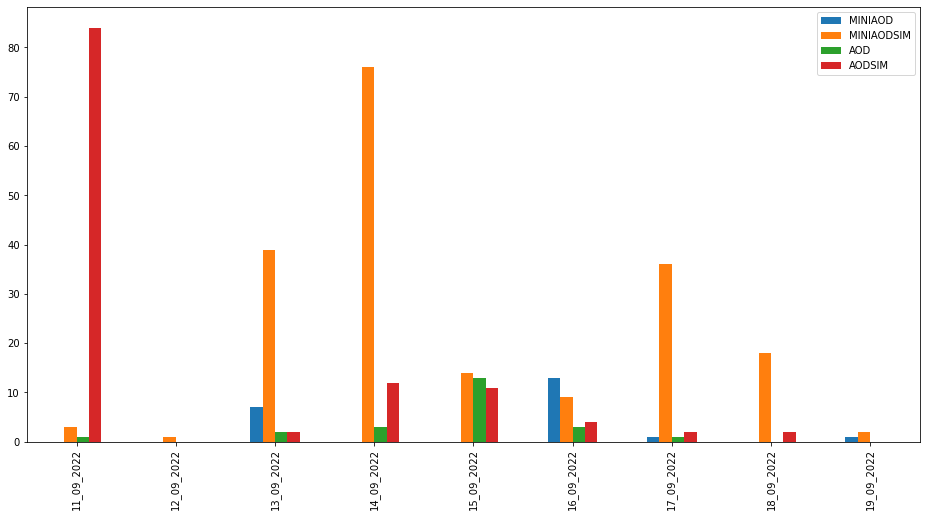

In [36]:
dict_count_datatier = get_count_new_unique_dataset_past_n_days(15, 10, pivot_on_datatier=True)
pd.DataFrame.from_dict(dict_count_datatier, orient='index').sort_index().plot.bar(figsize=(16,8))

Running for 0th day
Running for 1th day


22/09/20 00:32:35 WARN SharedInMemoryCache: Evicting cached table partition metadata from memory due to size constraints (spark.sql.hive.filesourcePartitionFileCacheSize = 262144000 bytes). This may impact query planning performance.


Running for 2th day
Running for 3th day
Running for 4th day
Running for 5th day
Running for 6th day
Running for 7th day
Running for 8th day
Running for 9th day


<AxesSubplot:>

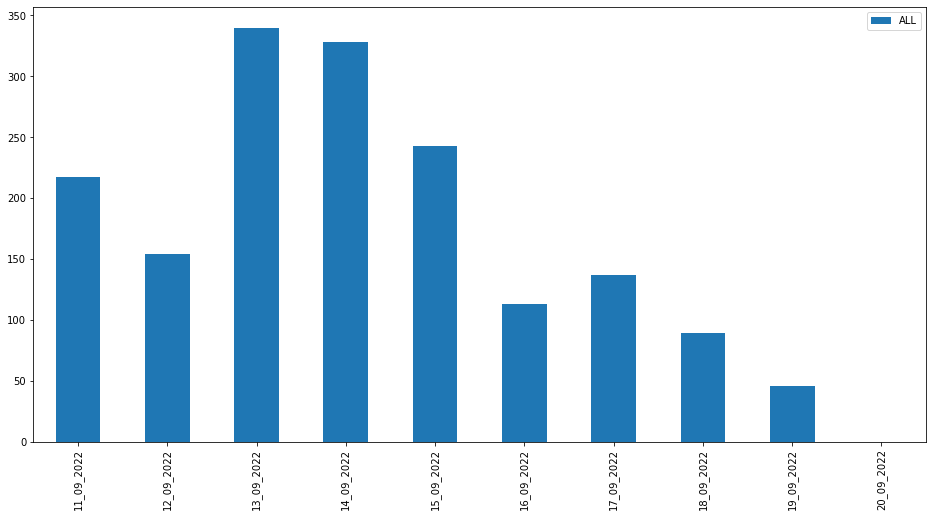

In [37]:
dict_count_total = get_count_new_unique_dataset_past_n_days(15, 10)
pd.DataFrame.from_dict(dict_count_total, orient='index').sort_index().plot.bar(figsize=(16,8))

### - [MEDIUM] histogram with the lifetime distribution of the datasets in the last 2y (lifetime == last request - first request)
	- normal histo and one weighetd by dataset size

> **We calculate lifetime as difference in dataset occurence dates in different workflows**

In [38]:
# Lifetime: Difference between latest(MaxDate) and first(MinDate) occurence of Dataset in Workflows
# Count: Number of occurence of Dataset in different Workflows (on how many different dates was the dataset requested in different workflows, this is because of datewiseunique=true)
# WeightedLifetime: Lifetime * Count (we may want to change how weight is applied)

def get_df_lifetime(n_days):

    today = date.today()
    windowPartitionDataset = Window.partitionBy("DESIRED_CMSDataset")
    df_ndays = get_dataset_per_day(n_days, today, datewiseUnique=False)

    df_lifetime = df_ndays\
        .withColumn("MaxDate", func.max(col('RecordDate')).over(windowPartitionDataset))\
        .withColumn("MinDate", func.min(col('RecordDate')).over(windowPartitionDataset))\
        .withColumn("Count", func.count(col('RecordDate')).over(windowPartitionDataset))\
        .withColumn("Lifetime", func.datediff(col("MaxDate"), col("MinDate")))\
        .withColumn("WeightedLifetime", col("Lifetime")*col("Count"))\
        .dropDuplicates(["DESIRED_CMSDataset"])\
        .select(["DESIRED_CMSDataset", "Lifetime", "WeightedLifetime", "Count", "CMSPrimaryDataTier"])
            
    return df_lifetime

In [39]:
def get_datatier_histograms(df, countColumn, pivotColumn=None, pivotList=None, n_bins=10):
    max_value, min_value = df.agg({countColumn: "max"}).collect()[0][0], 0
    bin_size = max_value/n_bins
    
    histogram = df.withColumn("bin", (col(countColumn)/bin_size).cast('int'))\
                  .groupBy("bin")
    
    if pivotColumn:
        histogram = histogram.pivot(pivotColumn, pivotList)

    histogram = histogram.count().collect()
    
    hist = {}
    for row in histogram:
        row_dict = row.asDict()
        hist[row_dict.pop('bin')] = row_dict
    
    print(hist)
    
    return hist
    
    

In [40]:
df_lifetime = get_df_lifetime(60)

22/09/20 02:28:45 WARN BlockManagerMaster: Failed to remove broadcast 392 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:684)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannel

{31: {'count': 70}, 53: {'count': 93}, 34: {'count': 55}, 28: {'count': 59}, 27: {'count': 11}, 44: {'count': 68}, 12: {'count': 15}, 22: {'count': 36}, 47: {'count': 106}, 1: {'count': 367}, 52: {'count': 61}, 26: {'count': 12}, 13: {'count': 97}, 16: {'count': 76}, 6: {'count': 191}, 3: {'count': 70}, 40: {'count': 66}, 20: {'count': 30}, 57: {'count': 170}, 54: {'count': 88}, 48: {'count': 73}, 5: {'count': 65}, 19: {'count': 50}, 41: {'count': 603}, 15: {'count': 53}, 43: {'count': 56}, 37: {'count': 24}, 17: {'count': 76}, 9: {'count': 26}, 35: {'count': 69}, 55: {'count': 99}, 59: {'count': 187}, 4: {'count': 84}, 8: {'count': 287}, 23: {'count': 116}, 39: {'count': 85}, 49: {'count': 31}, 7: {'count': 94}, 51: {'count': 7}, 10: {'count': 51}, 50: {'count': 26}, 45: {'count': 65}, 38: {'count': 272}, 25: {'count': 26}, 24: {'count': 153}, 29: {'count': 38}, 21: {'count': 22}, 32: {'count': 36}, 56: {'count': 186}, 11: {'count': 64}, 33: {'count': 65}, 14: {'count': 98}, 42: {'cou

<AxesSubplot:>

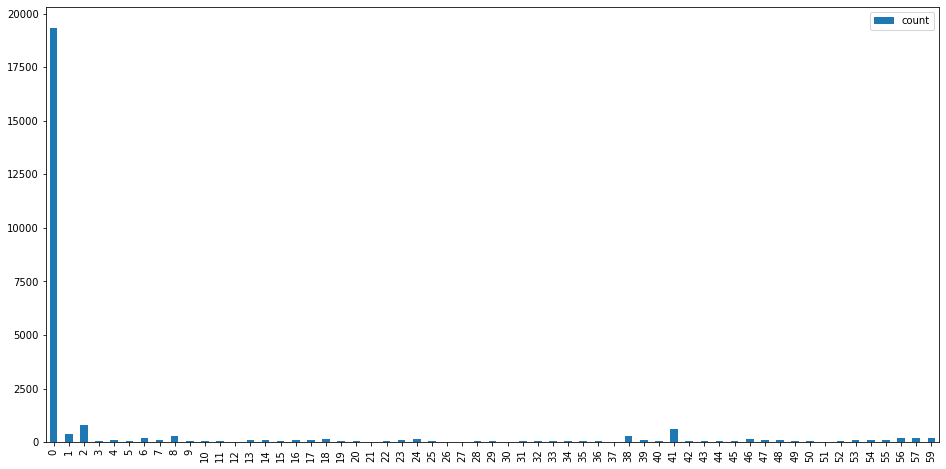

In [41]:
#Create and plot lifetime histogram for total datasets
hist_all_lifetime = get_datatier_histograms(df_lifetime, "Lifetime", n_bins=59)
pd.DataFrame.from_dict(hist_all_lifetime, orient='index').sort_index().plot.bar(figsize=(16,8))

{31: {'MINIAOD': 8, 'MINIAODSIM': 35, 'AOD': None, 'AODSIM': 1}, 53: {'MINIAOD': 38, 'MINIAODSIM': 37, 'AOD': 7, 'AODSIM': None}, 34: {'MINIAOD': 22, 'MINIAODSIM': 22, 'AOD': 3, 'AODSIM': None}, 28: {'MINIAOD': 2, 'MINIAODSIM': 36, 'AOD': 17, 'AODSIM': None}, 26: {'MINIAOD': 2, 'MINIAODSIM': 8, 'AOD': None, 'AODSIM': 1}, 27: {'MINIAOD': 1, 'MINIAODSIM': 9, 'AOD': None, 'AODSIM': None}, 44: {'MINIAOD': None, 'MINIAODSIM': 48, 'AOD': 5, 'AODSIM': None}, 12: {'MINIAOD': None, 'MINIAODSIM': 4, 'AOD': 5, 'AODSIM': 1}, 22: {'MINIAOD': 1, 'MINIAODSIM': 24, 'AOD': 2, 'AODSIM': None}, 47: {'MINIAOD': 2, 'MINIAODSIM': 31, 'AOD': None, 'AODSIM': 3}, 1: {'MINIAOD': 22, 'MINIAODSIM': 153, 'AOD': 8, 'AODSIM': 3}, 52: {'MINIAOD': 9, 'MINIAODSIM': 36, 'AOD': 1, 'AODSIM': None}, 13: {'MINIAOD': None, 'MINIAODSIM': 68, 'AOD': 5, 'AODSIM': None}, 16: {'MINIAOD': None, 'MINIAODSIM': 7, 'AOD': 4, 'AODSIM': None}, 6: {'MINIAOD': 16, 'MINIAODSIM': 75, 'AOD': 1, 'AODSIM': 14}, 3: {'MINIAOD': 2, 'MINIAODSIM': 

<AxesSubplot:>

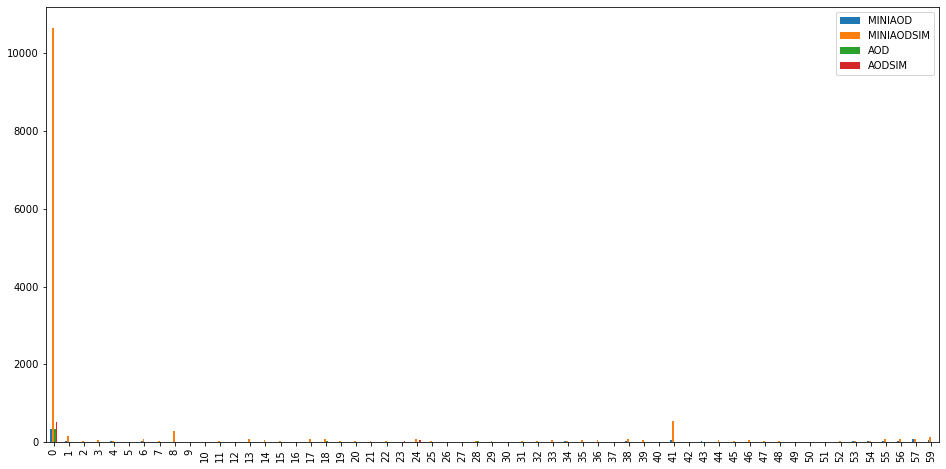

In [42]:
#Create and plot histogram for dataset lifetime by datatiers
hist_datatier_lifetime = get_datatier_histograms(df_lifetime, "Lifetime", "CMSPrimaryDataTier", ["MINIAOD","MINIAODSIM","AOD","AODSIM"], 59)
pd.DataFrame.from_dict(hist_datatier_lifetime, orient='index').sort_index().plot.bar(figsize=(16,8))

{59: {'count': 1}, 0: {'count': 25436}}


<AxesSubplot:>

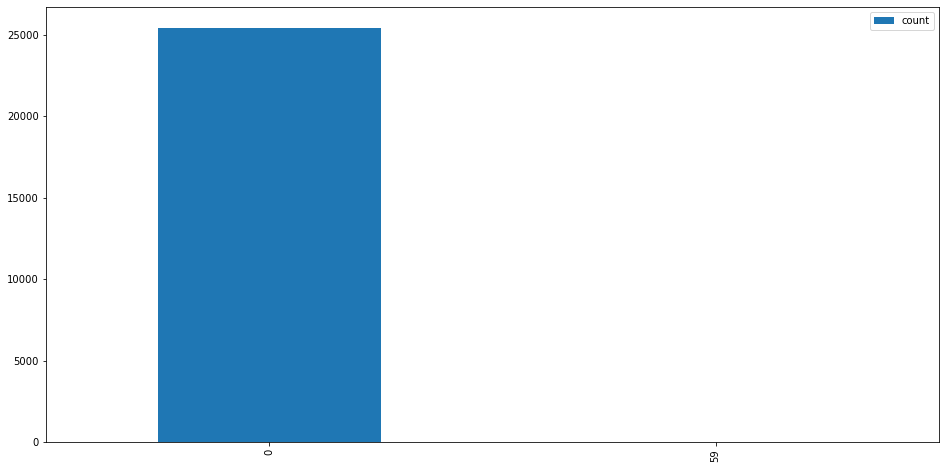

In [43]:
#Create and plot weighted lifetime histogram for total datasets
hist_all_weighted_lifetime = get_datatier_histograms(df_lifetime, "WeightedLifetime", n_bins=59)
pd.DataFrame.from_dict(hist_all_weighted_lifetime, orient='index').sort_index().plot.bar(figsize=(16,8))

{59: {'MINIAOD': None, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 1}, 0: {'MINIAOD': 890, 'MINIAODSIM': 13517, 'AOD': 494, 'AODSIM': 725}}


<AxesSubplot:>

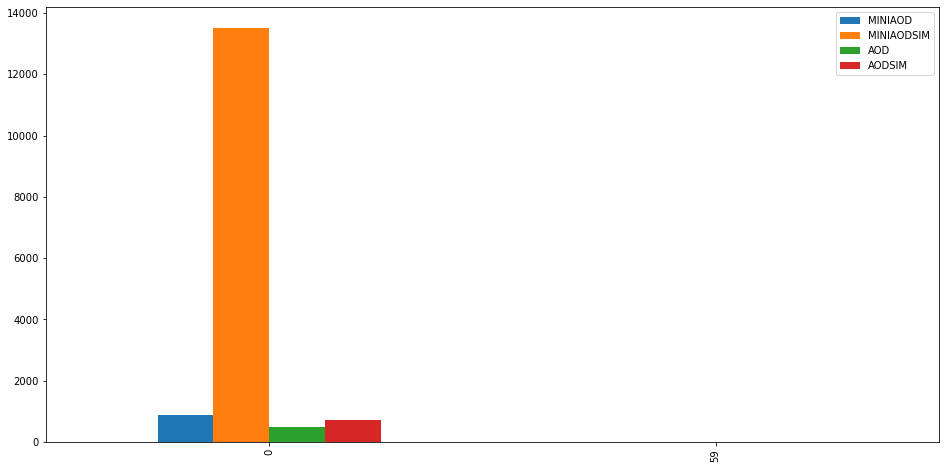

In [44]:
#Create and plot weighted lifetime histogram for dataset lifetime by datatiers
hist_datatier_weighted_lifetime = get_datatier_histograms(df_lifetime, "WeightedLifetime", "CMSPrimaryDataTier", ["MINIAOD","MINIAODSIM","AOD","AODSIM"], 59)
pd.DataFrame.from_dict(hist_datatier_weighted_lifetime, orient='index').sort_index().plot.bar(figsize=(16,8))

### [MEDIUM] histogram with the avg frequency distribution of the datasets in the last 2y
	- normal histo

> **We calculate frequency as count of dataset occurence in different workflows on different dates**

In [45]:
def get_df_dataset_datewise_frequency(n_days):
    today = date.today()
    df_ndays = get_dataset_per_day(n_days, today, datewiseUnique=True)
    df_freq = df_ndays\
                .groupby(["DESIRED_CMSDataset", "CMSPrimaryDataTier"])\
                .agg(func.count('RecordDate').alias("CountDistinctDates"))
    return df_freq

In [46]:
df_datewise_freq = get_df_dataset_datewise_frequency(60) 

{28: {'count': 5}, 12: {'count': 20}, 1: {'count': 2995}, 13: {'count': 18}, 27: {'count': 2}, 22: {'count': 3}, 6: {'count': 143}, 16: {'count': 23}, 3: {'count': 720}, 5: {'count': 267}, 19: {'count': 5}, 40: {'count': 2}, 20: {'count': 1}, 15: {'count': 12}, 31: {'count': 1}, 17: {'count': 13}, 9: {'count': 64}, 35: {'count': 1}, 4: {'count': 728}, 59: {'count': 1}, 8: {'count': 79}, 39: {'count': 4}, 23: {'count': 3}, 7: {'count': 125}, 10: {'count': 28}, 37: {'count': 3}, 38: {'count': 6}, 29: {'count': 4}, 21: {'count': 1}, 32: {'count': 1}, 11: {'count': 23}, 14: {'count': 16}, 2: {'count': 838}, 0: {'count': 19355}, 18: {'count': 4}, 36: {'count': 7}, 30: {'count': 1}}


<AxesSubplot:>

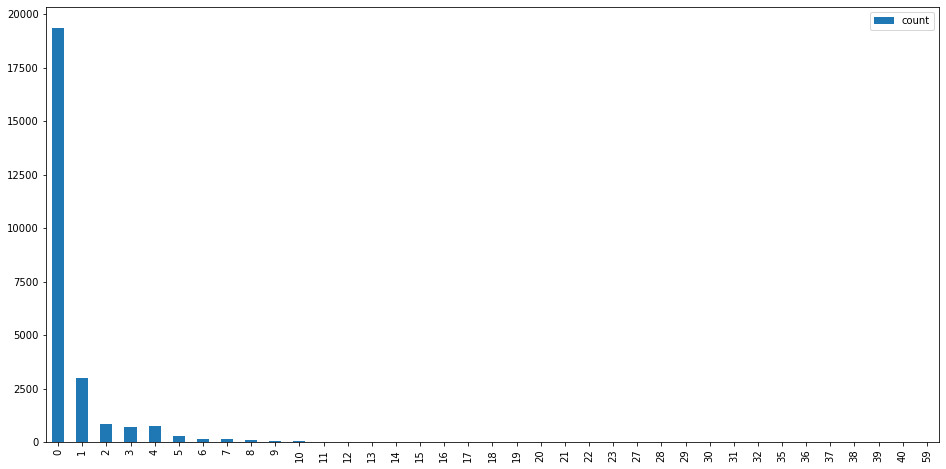

In [47]:
#Create and plot histogram for dataset frequency
hist_all_frequency = get_datatier_histograms(df_datewise_freq, "CountDistinctDates", n_bins=59)
pd.DataFrame.from_dict(hist_all_frequency, orient='index').sort_index().plot.bar(figsize=(16,8))

{31: {'MINIAOD': 1, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': None}, 28: {'MINIAOD': 4, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 1}, 27: {'MINIAOD': 1, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': None}, 12: {'MINIAOD': 3, 'MINIAODSIM': 14, 'AOD': None, 'AODSIM': None}, 22: {'MINIAOD': 1, 'MINIAODSIM': 2, 'AOD': None, 'AODSIM': None}, 1: {'MINIAOD': 169, 'MINIAODSIM': 1286, 'AOD': 48, 'AODSIM': 50}, 13: {'MINIAOD': 1, 'MINIAODSIM': 12, 'AOD': 1, 'AODSIM': None}, 16: {'MINIAOD': 19, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 1}, 6: {'MINIAOD': 27, 'MINIAODSIM': 63, 'AOD': 5, 'AODSIM': 6}, 3: {'MINIAOD': 69, 'MINIAODSIM': 363, 'AOD': 17, 'AODSIM': 15}, 20: {'MINIAOD': None, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': None}, 40: {'MINIAOD': None, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 2}, 5: {'MINIAOD': 39, 'MINIAODSIM': 85, 'AOD': 6, 'AODSIM': None}, 19: {'MINIAOD': 1, 'MINIAODSIM': 3, 'AOD': None, 'AODSIM': None}, 15: {'MINIAOD': 8, 'MINIAODSIM': 3, 'AOD': None, 'AODSIM': None}, 37:

<AxesSubplot:>

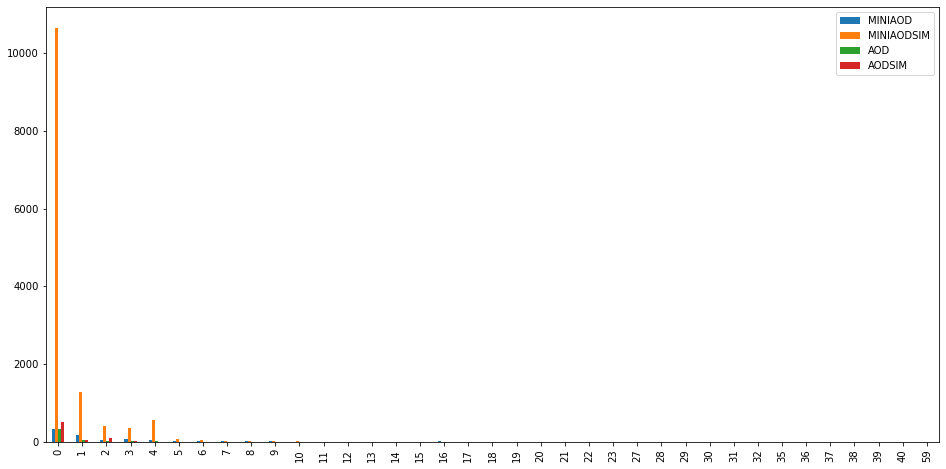

In [48]:
#Create and plot histogram for dataset frequency by datatiers
hist_datatier_frequency = get_datatier_histograms(df_datewise_freq, "CountDistinctDates", "CMSPrimaryDataTier", ["MINIAOD","MINIAODSIM","AOD","AODSIM"], 59)
pd.DataFrame.from_dict(hist_datatier_frequency, orient='index').sort_index().plot.bar(figsize=(16,8))

### [LOW] histogram with the dataset reuse distribution: number of different crab worflow requesting the ds
	- measuring in this way how much a LRU caching can help

> **1.We calculate reuse as count of dataset occurence in different workflows**

> **2.We calculate reuse as count of dataset occurence in different workflows on same date**

**reuse == count of dataset occurence in different workflows**

{1: {'count': 1}, 0: {'count': 25435}, 59: {'count': 1}}


<AxesSubplot:>

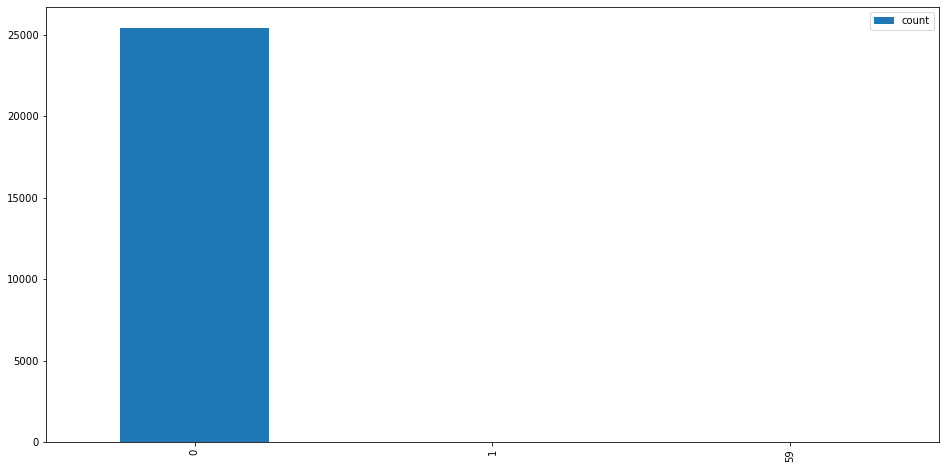

In [49]:

#Create and plot count histogram for total datasets
hist_all_count = get_datatier_histograms(df_lifetime, "Count", n_bins=59)
pd.DataFrame.from_dict(hist_all_count, orient='index').sort_index().plot.bar(figsize=(16,8))

{1: {'MINIAOD': None, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 1}, 59: {'MINIAOD': None, 'MINIAODSIM': None, 'AOD': None, 'AODSIM': 1}, 0: {'MINIAOD': 890, 'MINIAODSIM': 13517, 'AOD': 494, 'AODSIM': 724}}


<AxesSubplot:>

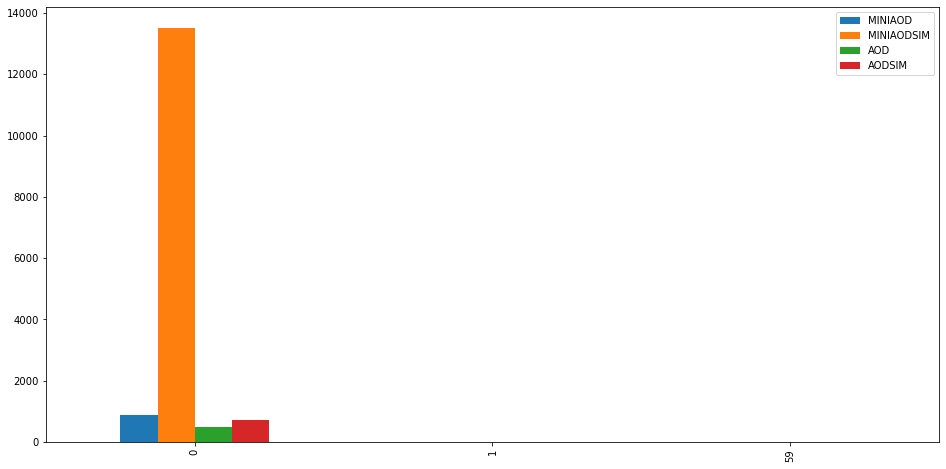

In [50]:
#Create and plot count histogram for dataset by datatiers
hist_datatier_count = get_datatier_histograms(df_lifetime, "Count", "CMSPrimaryDataTier", ["MINIAOD","MINIAODSIM","AOD","AODSIM"], 59)
pd.DataFrame.from_dict(hist_datatier_count, orient='index').sort_index().plot.bar(figsize=(16,8))

**reuse == count of dataset occurence in different workflows on same date**

In [51]:
def get_df_dataset_reuse_frequency(n_days):
    today = date.today()
    df_ndays = get_dataset_per_day(n_days, today, datewiseUnique=False)
    df_reuse = df_ndays\
                .groupby(["DESIRED_CMSDataset", "CMSPrimaryDataTier", "RecordDate"])\
                .agg(func.count(lit(1)).alias("ReuseCount"))
    return df_reuse

In [52]:
df_dataset_reuse = get_df_dataset_reuse_frequency(60)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



{1: {'count': 683}, 6: {'count': 19}, 3: {'count': 55}, 5: {'count': 21}, 13: {'count': 4}, 16: {'count': 11}, 19: {'count': 3}, 17: {'count': 3}, 4: {'count': 25}, 10: {'count': 10}, 14: {'count': 11}, 2: {'count': 129}, 0: {'count': 42174}, 15: {'count': 19}, 12: {'count': 1}, 9: {'count': 15}, 8: {'count': 4}, 7: {'count': 5}, 25: {'count': 1}, 11: {'count': 8}, 30: {'count': 1}, 29: {'count': 1}, 18: {'count': 2}, 59: {'count': 1}, 22: {'count': 1}, 24: {'count': 1}}


<AxesSubplot:>

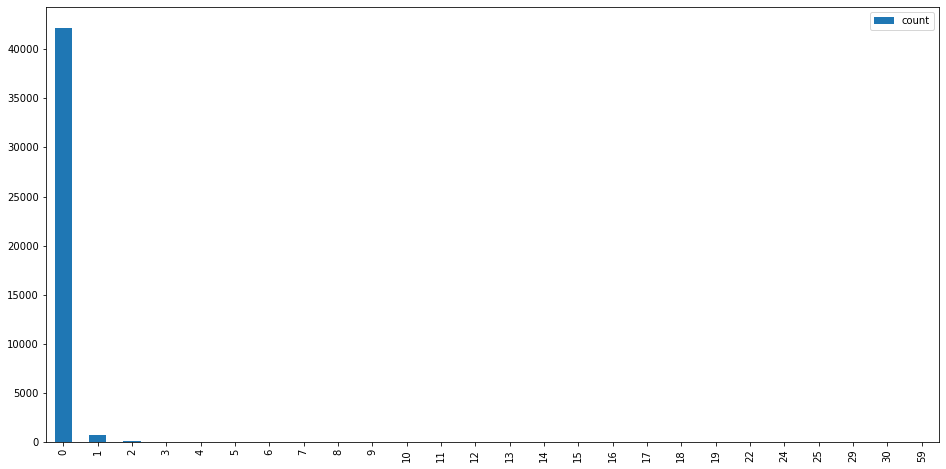

In [53]:
#Create and plot reuse count histogram for total datasets
hist_all_reuse = get_datatier_histograms(df_dataset_reuse, "ReuseCount", n_bins=59)
pd.DataFrame.from_dict(hist_all_reuse, orient='index').sort_index().plot.bar(figsize=(16,8))

In [ ]:
#Create and plot reuse count histogram for dataset by datatiers
hist_datatier_reuse = get_datatier_histograms(df_dataset_reuse, "ReuseCount", "CMSPrimaryDataTier", ["MINIAOD","MINIAODSIM","AOD","AODSIM"], 59)
pd.DataFrame.from_dict(hist_datatier_reuse, orient='index').sort_index().plot.bar(figsize=(16,8))

### [HIGH] pie chart with the average weekly/monthly amount of requested data by data tier


In [33]:
df_week = get_dataset_per_day(7, today)
pd_week = df_week.groupby("CMSPrimaryDataTier").count().toPandas()

NameError: name 'today' is not defined

In [ ]:
pd_week.set_index('CMSPrimaryDataTier').plot(kind='pie', y='count', figsize=(10, 10))

In [ ]:
df_month = get_dataset_per_day(30, today)
pd_month = df_month.groupby("CMSPrimaryDataTier").count().toPandas()

In [ ]:
pd_month.set_index('CMSPrimaryDataTier').plot(kind='pie', y='count', figsize=(10, 10))

## Rough Work

## Lifetime distribution of datasets

In [ ]:
def get_dataset_lifetime_histogram(days_range, end_date=date.today()):
    
    raw_df = get_raw_df(days_range, end_date)
    # We filter:
    # Events with Submission tool as CRAB
    # Select a single instace of CRAB_Workflow - our concerened field `DESIRED_CMSDataset` is same for all such rows (check assumption check 1)
    # Drop rows with DESIRED_CMSDataset as "null" - these are Monte Carlo jobs and do not require presence of datasets

    df_filtered = raw_df\
            .filter(col("CMS_SubmissionTool")=='CRAB')\
            .filter(col("DESIRED_CMSDataset")!='null')\
            .drop_duplicates(["CRAB_Workflow"])
    
    # We aggregate:
    # Group on DESIRED_CMSDataset
    # - count CRAB_Workflow: this represent the frequency of request of the dataset
    # - count CRAB_UserHN: (Question: how can this help us?) : frequency of unique users requesting that dataset 

    df_aggregated = df_filtered\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(
                 countDistinct(col("CRAB_Workflow")).alias("dataset_request_frequency")
                )\
            .orderBy(col('dataset_request_frequency').desc())
    
    return df_aggregated

In [ ]:
days_range, end_date = 730, date.today()
raw_df = get_raw_df(days_range, end_date)
df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset")!='null')
#         .drop_duplicates(["CRAB_Workflow"])

In [ ]:
df_dataset_recordTime = df.groupBy(["CRAB_Workflow", "DESIRED_CMSDataset"]).agg(func.min("RecordTime").alias("rec_time"))
df_lifetime = df_dataset_recordTime.groupby(["DESIRED_CMSDataset"]).agg(func.max("rec_time").alias("max_time"), func.min("rec_time").alias("min_time")).withColumn("lifetime", col("max_time")-col("min_time"))

In [ ]:
# df_lifetime.orderBy(col("lifetime").desc()).limit(10).toPandas()

In [ ]:
df_lifetime.filter(col("lifetime")>720*24*60*60*1000).limit(5).toPandas()

In [ ]:
#Exploring mappings between jobId and status
raw_df.filter(col("GlobalJobId")=="crab3@vocms0155.cern.ch#43338079.0#1566477179").orderBy(col('CpuTimeHr').desc()).limit(10).toPandas()

In [ ]:
raw_df.filter(col("CRAB_Workflow")=="220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8").limit(10).toPandas()

In [ ]:
raw_df.groupby("CRAB_Workflow").agg(countDistinct("status")).orderBy(col('count(status)').desc()).limit(10).toPandas()

In [ ]:
raw_df.groupby("CRAB_Workflow").agg(countDistinct("status")).orderBy(col('count(status)').asc()).limit(10).toPandas()

In [ ]:
my_df.count()

In [ ]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            ['/project/monitoring/archive/condor/raw/metric/2022/08/10'],
            schema=schema,
        )
        .select("data.*")
        .filter(col("CMS_SubmissionTool")=='CRAB')
    )

In [ ]:
raw_df_drop_jobid = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        )
        .select("data.*")
        .drop_duplicates(["GlobalJobId"])
)

raw_df_drop_workflow = raw_df_drop_jobid = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        )
        .select("data.*")
        .drop_duplicates(["Workflow"])
)

In [ ]:
raw_df.select(["Status", "DESIRED_CMSDataset", "CpuTimeHr", "GlobalJobId", "CMS_SubmissionTool", "CRAB_UserHN", "Workflow", "CRAB_Workflow"]).show(25)

In [ ]:
#Submission tool frequency by Unique Job Id counts
raw_df.groupby(["CMS_SubmissionTool"]).count().show()

In [ ]:
raw_df.drop_duplicates(["CRAB_Workflow"]).groupby("GlobalJobId").count().sort(col("count").desc()).limit(10).toPandas()

In [ ]:
raw_df.drop_duplicates(["GlobalJobId"]).groupby("CRAB_Workflow").count().sort(col("count").desc()).limit(10).toPandas()

In [ ]:
raw_df.filter(col("DESIRED_CMSDataset").contains("#")).select(["DESIRED_CMSDataset"]).show()

In [ ]:
raw_df.filter(col("Workflow")=="osuranyi_crab_JetHT_photons_HLTrerun").sort(col("CRAB_Workflow")).limit(10).toPandas()

In [ ]:
raw_df.filter(col("GlobalJobId")=="cmsgwms-submit4.fnal.gov#458695.77#1659948216").limit(10).toPandas()

In [ ]:
raw_df.groupby("GlobalJobId").count().limit(10).toPandas()

In [ ]:
raw_df.groupby("GlobalJobId").agg(countDistinct("DESIRED_CMSDataset")).filter(col("count(DESIRED_CMSDataset)")>1).show()

In [ ]:
raw_df.filter(col("CMS_SubmissionTool")=="CRAB").groupby("CRAB_Workflow").agg(countDistinct("DESIRED_CMSDataset")).filter(col("count(DESIRED_CMSDataset)")>1).show()

In [ ]:
my_df = raw_df.select(col('DESIRED_CMSDataset'),\
                    col('CpuTimeHr'),\
                    col('CRAB_UserHN'),\
                    col('CRAB_Workflow'))\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(_sum("CpuTimeHr").alias("sum_CpuTimeHr"),\
                countDistinct(col("CRAB_UserHN")).alias("distinct_CRAB_UserHN"),
                countDistinct(col("CRAB_Workflow")).alias("distinct_Workflow"))\
            .orderBy(col('distinct_CRAB_UserHN').desc())

In [ ]:
my_df.count()

In [ ]:
my_df.limit(20).toPandas()

### Assumption checks

#### Check 1: One to one mapping between DESIRED_CMSDataset and CRAB_Workflow

In [ ]:
raw_df.select(["DESIRED_CMSDataset", "CRAB_Workflow"]).groupby("CRAB_Workflow").agg(countDistinct("DESIRED_CMSDataset").alias("single_worflow_dataset_count")).filter(col("single_worflow_dataset_count") > 1).show()

In [ ]:
raw_df = get_raw_df(1)

In [ ]:
raw_df.filter(col("DESIRED_CMSDataset").isNull()).show(20,False)